In [263]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from datetime import datetime
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import xgboost as xgb
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from scipy.stats import ttest_rel

In [2]:
def balanced_weighted_average(sentiment_scores, decay_factor):
    """
    Calculate a balanced weighted average of sentiment scores without biasing towards negative values.
    
    Parameters:
    - sentiment_scores: A list or pandas Series of sentiment scores (positive and negative).
    - decay_factor: A value between 0 and 1 to control the decay rate of weights; defaults to 0.95.
    
    Returns:
    - A single balanced weighted average score.
    """
    # Initialize positive and negative scores with respective weights
    positive_scores = sentiment_scores[sentiment_scores > 0]
    negative_scores = sentiment_scores[sentiment_scores < 0]
    
    # Calculate decay weights for each score in reverse order (older scores get smaller weights)
    decay_weights = decay_factor ** np.arange(len(sentiment_scores))[::-1]

    # Separate weights for positive and negative scores
    pos_weights = decay_weights[:len(positive_scores)]
    neg_weights = decay_weights[:len(negative_scores)]

    # Calculate the weighted average for positive and negative scores separately
    pos_weighted_avg = (positive_scores * pos_weights).sum() / pos_weights.sum() if len(pos_weights) > 0 else 0
    neg_weighted_avg = (negative_scores * neg_weights).sum() / neg_weights.sum() if len(neg_weights) > 0 else 0

    # Return the balanced average by combining positive and negative averages equally
    balanced_avg = (pos_weighted_avg + neg_weighted_avg) / 2

    return balanced_avg

In [297]:
def compute_stock_sentiment_changes(stock_symbols, interval_days, decay_factor, start_date, end_date, include_volume, include_stock_news, include_global_news):
    """
    Computes stock sentiment changes and associated metrics.

    Parameters:
    - stock_symbols: List of stock symbols to process.
    - interval_days: Number of days for interval calculations.
    - decay_factor: Decay factor for weighted averages.
    - start_date: Start date for filtering data.
    - end_date: End date for filtering data.
    - include_volume: Boolean indicating whether to include volume data.
    - include_stock_news: Boolean indicating whether to include stock-specific news sentiment.
    - include_global_news: Boolean indicating whether to include global news sentiment.

    Returns:
    - Dictionary containing metrics DataFrames for each stock symbol.
    """
    # Initialize dictionaries to hold data
    df_stock_news_sentiment_scores_dict = {}
    df_news_sentiment_scores_dict = {}
    df_stock_data_dict = {}
    results = {}

    # Ensure dates are in datetime.date format
    if isinstance(start_date, str):
        start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
    if isinstance(end_date, str):
        end_date = datetime.strptime(end_date, '%Y-%m-%d').date()

    for symbol in stock_symbols:
        # Load data
        try:
            if include_stock_news:
                df_stock_news_sentiment_scores_dict[symbol] = pd.read_csv(
                    f'/Users/rishabhbhardwaj/Desktop/Bootcamp project/Sentiment_scores/stock_news_sentiment_scores/stock_news_sentiment_analysis_results_{symbol}.csv'
                )
            if include_global_news:
                df_news_sentiment_scores_dict[symbol] = pd.read_csv(
                    f'/Users/rishabhbhardwaj/Desktop/Bootcamp project/Sentiment_scores/news_sentiment_scores/2000-2024/sentiment_analysis_results_{symbol}.csv'
                )
            df_stock_data_dict[symbol] = pd.read_csv(
                f'/Users/rishabhbhardwaj/Desktop/Bootcamp project/stocks data/stock_data_{symbol}.csv'
            )
        except FileNotFoundError as e:
            print(f"Error loading data for {symbol}: {e}")
            continue

        # Rename sentiment score columns for clarity
        if include_global_news:
            df_news_sentiment_scores_dict[symbol] = df_news_sentiment_scores_dict[symbol].rename(
                columns={'weighted compound sentiment score': 'weighted compound news sentiment score'}
            )
        if include_stock_news:
            df_stock_news_sentiment_scores_dict[symbol] = df_stock_news_sentiment_scores_dict[symbol].rename(
                columns={'weighted compound sentiment score': 'weighted compound stock sentiment score'}
            )

        # Convert 'Date' columns to datetime.date format
        dataframes = [df_stock_data_dict[symbol]]
        if include_stock_news:
            dataframes.append(df_stock_news_sentiment_scores_dict[symbol])
        if include_global_news:
            dataframes.append(df_news_sentiment_scores_dict[symbol])

        for df in dataframes:
            df['Date'] = pd.to_datetime(df['Date']).dt.date

        # Filter data by date range
        filtered_stock = df_stock_data_dict[symbol][
            (df_stock_data_dict[symbol]['Date'] >= start_date) &
            (df_stock_data_dict[symbol]['Date'] <= end_date)
        ]
        if include_stock_news:
            filtered_stock_sentiment = df_stock_news_sentiment_scores_dict[symbol][
                (df_stock_news_sentiment_scores_dict[symbol]['Date'] >= start_date) &
                (df_stock_news_sentiment_scores_dict[symbol]['Date'] <= end_date)
            ]
        if include_global_news:
            filtered_news_sentiment = df_news_sentiment_scores_dict[symbol][
                (df_news_sentiment_scores_dict[symbol]['Date'] >= start_date) &
                (df_news_sentiment_scores_dict[symbol]['Date'] <= end_date)
            ]

        # Merge datasets
        merged_data = filtered_stock
        if include_stock_news:
            merged_data = pd.merge(merged_data, filtered_stock_sentiment, on='Date', how='left')
            merged_data['weighted compound stock sentiment score'].fillna(0, inplace=True)
        if include_global_news:
            merged_data = pd.merge(merged_data, filtered_news_sentiment, on='Date', how='left')
            merged_data['weighted compound news sentiment score'].fillna(0, inplace=True)

        # Sort data by date
        merged_data.sort_values(by='Date', inplace=True)

        # Filter rows based on sentiment score presence
        if include_stock_news and include_global_news:
            merged_data = merged_data[
                (merged_data['weighted compound stock sentiment score'] != 0) |
                (merged_data['weighted compound news sentiment score'] != 0)
            ]
        elif include_stock_news:
            merged_data = merged_data[merged_data['weighted compound stock sentiment score'] != 0]
        elif include_global_news:
            merged_data = merged_data[merged_data['weighted compound news sentiment score'] != 0]

        # Check if sufficient data exists
        if len(merged_data) < interval_days:
            print(f"Not enough data for {symbol} with interval_days = {interval_days}. Skipping.")
            continue

        # Initialize lists to store metrics
        price_diff_list, balanced_avg_stock_sentiment_list, balanced_avg_news_sentiment_list = [], [], []
        sma_list, sma_diff_list, date_list, volume_list = [], [], [], []

        # Compute metrics
        for i in range(len(merged_data) - interval_days + 1):
            date_d = merged_data['Date'].iloc[i + interval_days - 1]
            volume_d = merged_data['Volume'].iloc[i + interval_days - 1] if include_volume else None

            # Price difference
            close_d = merged_data['Close'].iloc[i]
            close_d_T = merged_data['Close'].iloc[i + interval_days - 1]
            price_diff = close_d_T - close_d

            # SMA
            sma = merged_data['Close'].iloc[i:i + interval_days].mean()

            # Balanced weighted averages
            if include_stock_news:
                stock_sentiment_scores = merged_data['weighted compound stock sentiment score'].iloc[i:i + interval_days]
                balanced_avg_stock_sentiment = balanced_weighted_average(stock_sentiment_scores, decay_factor)
                balanced_avg_stock_sentiment_list.append(balanced_avg_stock_sentiment)
            if include_global_news:
                news_sentiment_scores = merged_data['weighted compound news sentiment score'].iloc[i:i + interval_days]
                balanced_avg_news_sentiment = balanced_weighted_average(news_sentiment_scores, decay_factor)
                balanced_avg_news_sentiment_list.append(balanced_avg_news_sentiment)

            # SMA difference
            sma_diff = 0 if len(sma_list) > 0 and sma_list[-1] > sma else 1

            # Append metrics
            date_list.append(date_d)
            price_diff_list.append(price_diff)
            sma_list.append(sma)
            sma_diff_list.append(sma_diff)
            if include_volume:
                volume_list.append(volume_d)

        # Store results
        results[symbol] = pd.DataFrame({
            'Date': date_list,
            f'{symbol}_Price_Diff_{interval_days}d': price_diff_list,
            f'{symbol}_SMA_{interval_days}d': sma_list,
            f'{symbol}_SMA_Diff_{interval_days}d': sma_diff_list
        })
        if include_volume:
            results[symbol][f'{symbol}_Volume_Traded_{interval_days}d'] = volume_list
        if include_stock_news:
            results[symbol][f'{symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d'] = balanced_avg_stock_sentiment_list
        if include_global_news:
            results[symbol][f'{symbol}_Balanced_Avg_News_Sentiment_{interval_days}d'] = balanced_avg_news_sentiment_list

    return results

In [355]:
stock_symbols = ['GOOG', 'MSFT', 'NVDA','AMZN','AAPL']
interval_days = 14
decay_factor = 0.95
results = compute_stock_sentiment_changes(stock_symbols, interval_days, decay_factor, start_date='2011-05-16', end_date='2024-11-11', include_volume=True, include_stock_news=True, include_global_news = True)

/var/folders/wd/hyh_v63j2k7_v0q1j5942x3r0000gn/T/ipykernel_78189/4159496838.py:88: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['weighted compound stock sentiment score'].fillna(0, inplace=True)
/var/folders/wd/hyh_v63j2k7_v0q1j5942x3r0000gn/T/ipykernel_78189/4159496838.py:91: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

In [356]:
results['GOOG']

,Date,GOOG_Price_Diff_14d,GOOG_SMA_14d,GOOG_SMA_Diff_14d,GOOG_Volume_Traded_14d,GOOG_Balanced_Avg_Stock_Sentiment_14d,GOOG_Balanced_Avg_News_Sentiment_14d
0,2011-06-23,-0.953594,12.719844,1,191875932,-0.063041,-0.064214
1,2011-06-24,-1.371228,12.642209,0,152071776,-0.068181,-0.077107
2,2011-06-27,-0.920394,12.558386,0,137650212,-0.068181,-0.107566
3,2011-06-28,-0.611098,12.511990,0,108495396,-0.028628,-0.089835
4,2011-06-29,-0.582391,12.475330,0,93626280,0.072267,-0.125294
...,...,...,...,...,...,...,...
1869,2024-09-23,5.607330,156.388881,1,24150900,0.100205,-0.092850
1870,2024-09-24,5.258362,156.820832,1,23332100,0.112264,-0.092850
1871,2024-09-25,10.770004,157.139288,1,18869200,0.111159,-0.092850
1872,2024-09-26,14.019989,157.997144,1,20319300,0.098241,-0.092850


In [315]:
def fit_sentiments_vs_metric_as_mlr_kfold(stock_symbols, results, interval_days, metric, 
                                          include_volume, include_stock_news, include_global_news, 
                                          n_splits=5):
    """
    Fits multilinear regression of sentiment scores against either SMA or price difference using K-Fold cross-validation.

    Parameters:
    - stock_symbols: List of stock symbols to process.
    - results: Dictionary with stock data DataFrames.
    - interval_days: The interval of days over which metrics are calculated.
    - metric: Specify either 'sma' or 'price_diff' to choose which metric to plot.
    - include_volume: Boolean to include volume data as a feature.
    - include_stock_news: Boolean to include stock news sentiment as a feature.
    - include_global_news: Boolean to include global news sentiment as a feature.
    - n_splits: Number of splits for K-Fold cross-validation.

    Returns:
    - Dictionary containing models, average MSEs, and per-fold MSEs for each stock symbol.
    """
    # Initialize dictionaries to store models and MSEs
    mlr_model = {}
    avg_mse = {}
    fold_mse = {}

    for symbol in stock_symbols:
        # Construct feature and target column names dynamically
        features = []
        if include_global_news:
            features.append(f'{symbol}_Balanced_Avg_News_Sentiment_{interval_days}d')
        if include_stock_news:
            features.append(f'{symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d')
        if include_volume:
            features.append(f'{symbol}_Volume_Traded_{interval_days}d')

        if metric == 'sma':
            metric_col = f'{symbol}_SMA_{interval_days}d'
        elif metric == 'price_diff':
            metric_col = f'{symbol}_Price_Diff_{interval_days}d'
        else:
            print(f"Unknown metric '{metric}'. Choose 'sma' or 'price_diff'. Skipping.")
            continue

        # Check if the expected columns exist in the DataFrame for the current symbol
        if symbol in results and all(col in results[symbol].columns for col in features + [metric_col]):
            # Extract features and target
            X = results[symbol][features].values
            y = results[symbol][metric_col].values

            # Initialize K-Fold cross-validation
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

            fold_mse[symbol] = []
            fold_models = []

            # Perform K-Fold cross-validation
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Define the pipeline
                pipeline = Pipeline([
                    ('scale', StandardScaler()),
                    ('mlr', LinearRegression())
                ])

                # Fit the model and predict
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)

                # Calculate and store MSE for this fold
                fold_mse[symbol].append(mse(y_test, y_pred))

                # Save the trained model for this fold
                fold_models.append(pipeline)

            # Calculate the average MSE across folds
            avg_mse[symbol] = np.mean(fold_mse[symbol])

            # Store the models for this symbol
            mlr_model[symbol] = fold_models

            print(f"{symbol}: Model fitted. Average MSE = {avg_mse[symbol]:.4f}")
        else:
            print(f"Required columns for {symbol} with interval {interval_days} days not found. Skipping.")

    return {'models': mlr_model, 'avg_mse': avg_mse, 'fold_mse': fold_mse}

In [345]:
fit_sentiments_vs_metric_as_mlr_kfold(stock_symbols, results, interval_days, 'sma', include_volume = True, include_stock_news = True, include_global_news = True)

GOOG: Model fitted. Average MSE = 1790.5786
MSFT: Model fitted. Average MSE = 15594.8693
NVDA: Model fitted. Average MSE = 803.4707
AMZN: Model fitted. Average MSE = 3466.0852
AAPL: Model fitted. Average MSE = 2724.8308


{'models': {'GOOG': [Pipeline(steps=[('scale', StandardScaler()), ('mlr', LinearRegression())]),
   Pipeline(steps=[('scale', StandardScaler()), ('mlr', LinearRegression())]),
   Pipeline(steps=[('scale', StandardScaler()), ('mlr', LinearRegression())]),
   Pipeline(steps=[('scale', StandardScaler()), ('mlr', LinearRegression())]),
   Pipeline(steps=[('scale', StandardScaler()), ('mlr', LinearRegression())])],
  'MSFT': [Pipeline(steps=[('scale', StandardScaler()), ('mlr', LinearRegression())]),
   Pipeline(steps=[('scale', StandardScaler()), ('mlr', LinearRegression())]),
   Pipeline(steps=[('scale', StandardScaler()), ('mlr', LinearRegression())]),
   Pipeline(steps=[('scale', StandardScaler()), ('mlr', LinearRegression())]),
   Pipeline(steps=[('scale', StandardScaler()), ('mlr', LinearRegression())])],
  'NVDA': [Pipeline(steps=[('scale', StandardScaler()), ('mlr', LinearRegression())]),
   Pipeline(steps=[('scale', StandardScaler()), ('mlr', LinearRegression())]),
   Pipeline(step

In [317]:
def run_multilinear_regression(results, stock_symbol, interval_days, 
                               include_volume, include_stock_news, 
                               include_global_news, metric):
    """
    Runs a multilinear regression of balanced average news and stock sentiment scores
    against either SMA or price difference.

    Parameters:
    - results: Dictionary with stock data DataFrames.
    - stock_symbol: The symbol of the stock to analyze.
    - interval_days: The interval of days over which metrics are calculated.
    - include_volume: Boolean to include volume data as a predictor.
    - include_stock_news: Boolean to include stock news sentiment as a predictor.
    - include_global_news: Boolean to include global news sentiment as a predictor.
    - metric: Specify either 'sma' or 'price_diff' to choose which metric to analyze.
    """
    # Define predictor columns dynamically based on the flags
    predictors = []
    if include_global_news:
        predictors.append(f'{stock_symbol}_Balanced_Avg_News_Sentiment_{interval_days}d')
    if include_stock_news:
        predictors.append(f'{stock_symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d')
    if include_volume:
        predictors.append(f'{stock_symbol}_Volume_Traded_{interval_days}d')

    # Define the target column
    if metric == 'sma':
        metric_col = f'{stock_symbol}_SMA_{interval_days}d'
    elif metric == 'price_diff':
        metric_col = f'{stock_symbol}_Price_Diff_{interval_days}d'
    else:
        print(f"Unknown metric '{metric}'. Choose 'sma' or 'price_diff'.")
        return

    # Check if the required columns exist in the DataFrame
    if stock_symbol in results and \
       all(col in results[stock_symbol].columns for col in predictors + [metric_col]):
        
        # Extract predictors and the target
        X = results[stock_symbol][predictors].values
        y = results[stock_symbol][metric_col].values
        
        # Add a constant to the predictors for the intercept
        X_with_const = sm.add_constant(X)

        # Fit the OLS model
        model_ols = sm.OLS(y, X_with_const)
        results_ols = model_ols.fit()

        # Print the summary to see coefficients and other statistics
        print(results_ols.summary())

        # Get the confidence intervals for the coefficients
        confidence_intervals = results_ols.conf_int(alpha=0.05)  # 95% CI by default
        print("Confidence intervals:\n", confidence_intervals)
    else:
        print(f"Required columns for {stock_symbol} with interval {interval_days} days and metric '{metric}' not found in results.")

In [319]:
# Define the parameters
stock_symbol = 'AAPL'
metric = 'sma'  

# Run the multilinear regression
run_multilinear_regression(results, stock_symbol, interval_days, include_global_news=True, include_stock_news=True, include_volume=True, metric=metric)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     312.8
Date:                Mon, 25 Nov 2024   Prob (F-statistic):          2.23e-161
Time:                        23:33:47   Log-Likelihood:                -9054.5
No. Observations:                1686   AIC:                         1.812e+04
Df Residuals:                    1682   BIC:                         1.814e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        143.0695      1.822     78.509      0.0

In [276]:
def random_guess_baseline(stock_symbols, results, interval_days, metric):
    """
    Implements a random guess baseline for binary classification without explicit splitting.

    Parameters:
    - stock_symbols: List of stock symbols to process.
    - results: Dictionary with stock data DataFrames.
    - interval_days: The interval of days over which metrics are calculated.
    - metric: Specify the target column ('sma' or 'price_diff') for classification.

    Returns:
    - DataFrame containing metrics for each stock symbol.
    """
    # Initialize dictionary to store metrics
    metrics = {}

    for symbol in stock_symbols:
        # Construct column names
        metric_col = f'{symbol}_SMA_Diff_{interval_days}d' if metric == 'sma' else f'{symbol}_Price_Diff_{interval_days}d'

        # Check if the required column exists
        if symbol in results and metric_col in results[symbol].columns:
            # Extract target
            data = results[symbol][[metric_col]].dropna()
            y = data[metric_col].values

            # Handle cases where y has fewer positive or negative samples
            if len(set(y)) < 2:
                print(f"Insufficient class variation for {symbol}. Skipping.")
                continue

            # Generate random predictions with probabilities matching class distribution
            class_probabilities = [np.mean(y == 0), np.mean(y == 1)]
            y_pred = np.random.choice([0, 1], size=len(y), p=class_probabilities)

            # Compute confusion matrix
            tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

            # Calculate metrics
            acc = accuracy_score(y, y_pred)
            spec = tn / (tn + fp) if (tn + fp) > 0 else 0
            rec = tp / (tp + fn) if (tp + fn) > 0 else 0
            prec = tp / (tp + fp) if (tp + fp) > 0 else 0
            npv = tn / (tn + fn) if (tn + fn) > 0 else 0
            f1 = f1_score(y, y_pred)
            roc_auc = roc_auc_score(y, y_pred)

            # Store metrics for the symbol
            metrics[symbol] = {
                "accuracy": acc,
                "specificity": spec,
                "recall": rec,
                "precision": prec,
                "NPV": npv,
                "f1_score": f1,
                "roc_auc": roc_auc
            }

    # Convert metrics to a DataFrame
    metrics_df = pd.DataFrame(metrics)
    metrics_df.reset_index(inplace=True)
    metrics_df = metrics_df.rename(columns={"index": "Metrics"})

    return metrics_df

In [340]:
def fit_sentiments_vs_metric_as_log_reg(stock_symbols, results, interval_days, 
                                        include_volume, include_stock_news, 
                                        include_global_news, n_splits=5):
    """
    Fits logistic regression and calculates metrics with an option to include/exclude specific features.
    Runs K-Fold cross-validation tests.

    Parameters:
    - stock_symbols: List of stock symbols to process.
    - results: Dictionary with stock data DataFrames.
    - interval_days: The interval of days over which metrics are calculated.
    - include_volume: Boolean to include volume data as a feature.
    - include_stock_news: Boolean to include stock news sentiment as a feature.
    - include_global_news: Boolean to include global news sentiment as a feature.
    - metric: Specify either 'sma' or 'price_diff' to choose which metric to analyze.
    - n_splits: The number of K-Fold cross-validation splits.

    Returns:
    - df_metrics: DataFrame containing average metrics across folds for each stock.
    - models: Dictionary containing models for each stock symbol.
    - fold_metrics: Dictionary containing metrics for each fold for each stock.
    """
    # Initialize dictionaries to store models and metrics
    models = {}
    df_metrics = {}
    fold_metrics = {}

    for symbol in stock_symbols:
        # Dynamically construct feature column names based on flags
        features = []
        if include_stock_news:
            features.append(f'{symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d')
        if include_global_news:
            features.append(f'{symbol}_Balanced_Avg_News_Sentiment_{interval_days}d')
        if include_volume:
            features.append(f'{symbol}_Volume_Traded_{interval_days}d')

        # Define the target column
        metric_col = f'{symbol}_SMA_Diff_{interval_days}d'

        # Check if required columns exist
        if symbol in results and all(col in results[symbol].columns for col in features + [metric_col]):
            # Prepare the data
            data = results[symbol][features + [metric_col]].dropna()
            X = data[features].values
            y = data[metric_col].values

            # Initialize K-Fold cross-validation
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

            fold_metrics[symbol] = {
                "accuracy": [],
                "specificity": [],
                "recall": [],
                "precision": [],
                "NPV": [],
                "f1_score": [],
                "roc_auc": []
            }
            fold_models = []

            # Perform K-Fold cross-validation
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Fit logistic regression
                log_reg_model = Pipeline([
                    ('scale', StandardScaler()),
                    ('log_reg', LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000))
                ])
                log_reg_model.fit(X_train, y_train)
                y_pred = log_reg_model.predict(X_test)
                y_proba = log_reg_model.predict_proba(X_test)[:, 1]

                # Compute confusion matrix
                tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

                # Calculate metrics
                acc = accuracy_score(y_test, y_pred)
                spec = tn / (tn + fp) if (tn + fp) > 0 else 0
                rec = tp / (tp + fn) if (tp + fn) > 0 else 0
                prec = tp / (tp + fp) if (tp + fp) > 0 else 0
                npv = tn / (tn + fn) if (tn + fn) > 0 else 0
                f1 = f1_score(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_proba)

                # Append metrics
                fold_metrics[symbol]["accuracy"].append(acc)
                fold_metrics[symbol]["specificity"].append(spec)
                fold_metrics[symbol]["recall"].append(rec)
                fold_metrics[symbol]["precision"].append(prec)
                fold_metrics[symbol]["NPV"].append(npv)
                fold_metrics[symbol]["f1_score"].append(f1)
                fold_metrics[symbol]["roc_auc"].append(roc_auc)

                # Save the model for this fold
                fold_models.append(log_reg_model)

            # Store average metrics across folds
            df_metrics[symbol] = {
                "accuracy": np.mean(fold_metrics[symbol]["accuracy"]),
                "specificity": np.mean(fold_metrics[symbol]["specificity"]),
                "recall": np.mean(fold_metrics[symbol]["recall"]),
                "precision": np.mean(fold_metrics[symbol]["precision"]),
                "NPV": np.mean(fold_metrics[symbol]["NPV"]),
                "f1_score": np.mean(fold_metrics[symbol]["f1_score"]),
                "roc_auc": np.mean(fold_metrics[symbol]["roc_auc"])
            }

            # Save all models for this symbol
            models[symbol] = fold_models

        else:
            print(f"Required columns for {symbol} with interval {interval_days} days and metric '{metric}' not found in results. Skipping.")

    # Convert metrics to a DataFrame
    df_metrics = pd.DataFrame.from_dict(df_metrics, orient='index').reset_index()
    df_metrics.rename(columns={'index': 'Stock'}, inplace=True)

    return df_metrics, models, fold_metrics

In [341]:
fit_sentiments_vs_metric_as_log_reg(stock_symbols, results, interval_days, include_global_news=True, include_volume=True, include_stock_news=True)[0]

,Stock,accuracy,specificity,recall,precision,NPV,f1_score,roc_auc
0,GOOG,0.613131,0.076582,0.949800,0.620719,0.494160,0.750303,0.573010
1,MSFT,0.667508,0.087038,0.966107,0.673707,0.595893,0.793356,0.604986
2,NVDA,0.665071,0.000000,1.000000,0.665071,0.000000,0.798759,0.459243
3,AMZN,0.652460,0.233823,0.895618,0.668736,0.563485,0.765235,0.650889
4,AAPL,0.634639,0.170539,0.922897,0.641853,0.574335,0.756874,0.642917


In [337]:
def fit_sentiments_vs_metric_as_xgb_kfold(stock_symbols, results, interval_days, include_volume, include_stock_news, include_global_news, n_splits=5):
    """
    Performs K-Fold cross-validation for XGBoost classifiers and calculates metrics.

    Parameters:
    - stock_symbols: List of stock symbols to process.
    - results: Dictionary with stock data DataFrames.
    - interval_days: The interval of days over which metrics are calculated.
    - include_news_sentiment: Boolean indicating whether to include news sentiment scores as features.
    - n_splits: Number of splits for K-Fold cross-validation.

    Returns:
    - DataFrame containing average metrics for each stock symbol across folds.
    - Dictionary containing trained models for each stock symbol.
    """
    # Initialize dictionaries to store models and metrics
    models = {}
    df_metrics = {}
    fold_metrics = {}

    for symbol in stock_symbols:
        # Dynamically construct feature column names based on flags
        features = []
        if include_stock_news:
            features.append(f'{symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d')
        if include_global_news:
            features.append(f'{symbol}_Balanced_Avg_News_Sentiment_{interval_days}d')
        if include_volume:
            features.append(f'{symbol}_Volume_Traded_{interval_days}d')
        
        metric_col = f'{symbol}_SMA_Diff_{interval_days}d'

        # Check if required columns exist
        if symbol in results and all(col in results[symbol].columns for col in features + [metric_col]):
            # Prepare the data
            data = results[symbol][features + [metric_col]].dropna()
            X = data[features].values
            y = data[metric_col].values

            # Initialize K-Fold cross-validation
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

            fold_metrics[symbol] = {
                "accuracy": [],
                "specificity": [],
                "recall": [],
                "precision": [],
                "NPV": [],
                "f1_score": [],
                "roc_auc": []
            }
            fold_models = []


            # Handle cases where y has fewer positive or negative samples
            if len(set(y)) < 2:
                print(f"Insufficient class variation for {symbol}. Skipping.")
                continue

            # Initialize K-Fold cross-validation
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

            fold_metrics[symbol] = {
                "accuracy": [],
                "specificity": [],
                "recall": [],
                "precision": [],
                "NPV": [],
                "f1_score": [],
                "roc_auc": []
            }
            fold_models = []

            # Perform K-Fold cross-validation
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Compute scale_pos_weight for class imbalance
                scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1]) if len(y_train[y_train == 1]) > 0 else 1

                # Train XGBoost model
                xgb_model = Pipeline([
                ('scale', StandardScaler()),
                ('xgb_reg', xgb.XGBClassifier(
                    scale_pos_weight=scale_pos_weight,
                    eval_metric="logloss"  # Specify evaluation metric
                ))
            ]) 
                xgb_model.fit(X_train, y_train)
                y_pred = xgb_model.predict(X_test)
                y_proba = xgb_model.predict_proba(X_test)[:, 1]

                # Compute confusion matrix
                tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

                # Calculate metrics
                acc = accuracy_score(y_test, y_pred)
                spec = tn / (tn + fp) if (tn + fp) > 0 else 0
                rec = tp/(tp+fn) if (tp+fn) > 0 else 0 
                prec = tp/(tp+fp) if (tp+fp) > 0 else 0
                prec = tp/(tp+fp) if (tp+fp) > 0 else 0   
                npv = tn/(tn+fn) if (tn+fn) > 0 else 0

                f1 = f1_score(y_test, y_pred)  
                roc_auc = roc_auc_score(y_test, y_proba)

                # Append metrics
                fold_metrics[symbol]["accuracy"].append(acc)
                fold_metrics[symbol]["specificity"].append(spec)
                fold_metrics[symbol]["recall"].append(rec)
                fold_metrics[symbol]["precision"].append(prec)
                fold_metrics[symbol]["NPV"].append(npv)
                fold_metrics[symbol]["f1_score"].append(f1)
                fold_metrics[symbol]["roc_auc"].append(roc_auc)

                # Save the model for this fold
                fold_models.append(xgb_model)

            # Store average metrics across folds
            df_metrics[symbol] = {
                "accuracy": np.mean(fold_metrics[symbol]["accuracy"]),
                "specificity": np.mean(fold_metrics[symbol]["specificity"]),
                "recall": np.mean(fold_metrics[symbol]["recall"]),
                "precision": np.mean(fold_metrics[symbol]["precision"]),
                "NPV": np.mean(fold_metrics[symbol]["NPV"]),
                "f1_score": np.mean(fold_metrics[symbol]["f1_score"]),
                "roc_auc": np.mean(fold_metrics[symbol]["roc_auc"])
            }

            # Save all models for this symbol
            models[symbol] = fold_models

    # Convert metrics to a DataFrame
    df_metrics = pd.DataFrame(df_metrics)
    df_metrics.reset_index(inplace=True)
    df_metrics = df_metrics.rename(columns={"index": "Metrics"})

    return df_metrics, models, fold_metrics

In [338]:
XGB_model_without_news = fit_sentiments_vs_metric_as_xgb_kfold(stock_symbols, results, interval_days, include_global_news=False, include_stock_news=True, include_volume=True)
XGB_model_with_news = fit_sentiments_vs_metric_as_xgb_kfold(stock_symbols, results, interval_days, include_global_news=True, include_stock_news=True, include_volume=True)
XGB_model_with_volume = fit_sentiments_vs_metric_as_xgb_kfold(stock_symbols, results, interval_days, include_global_news=False, include_stock_news=False, include_volume=True)

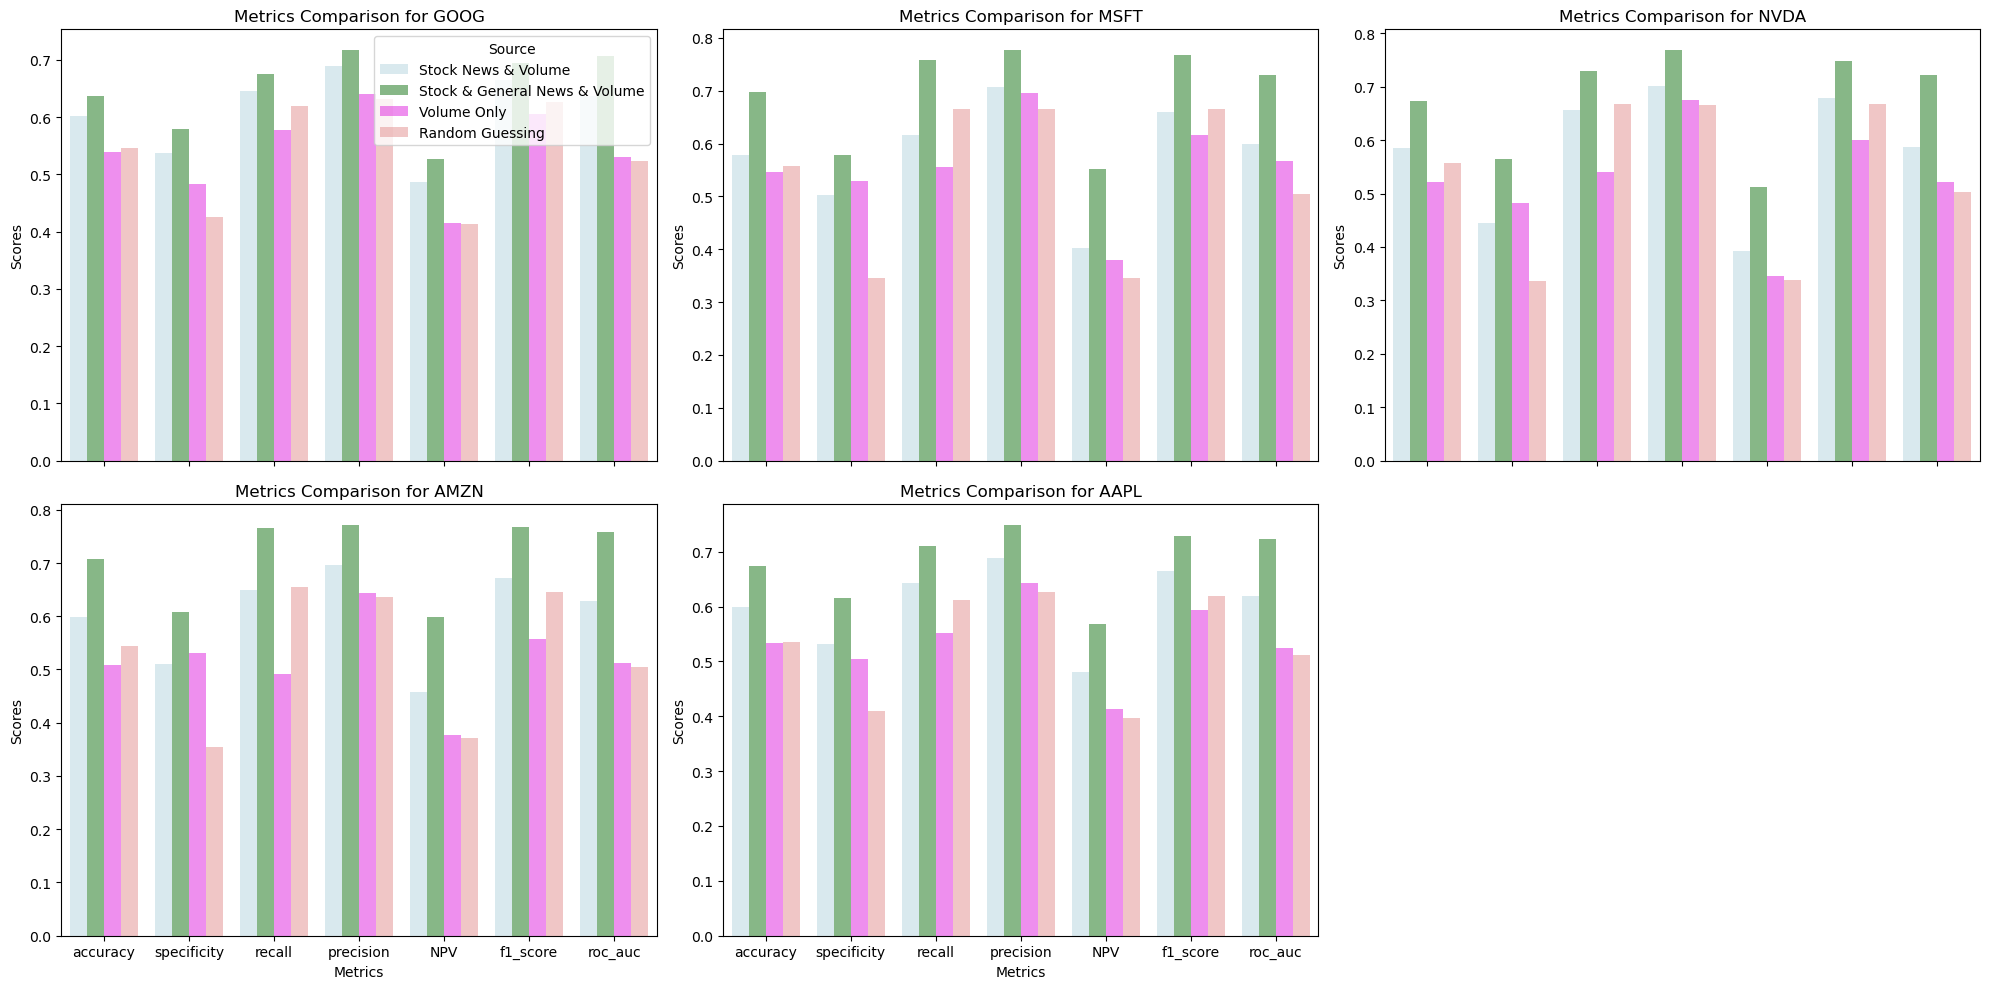

In [342]:
y_without_news = XGB_model_without_news[0]
y_with_news = XGB_model_with_news[0]
y_with_volume = XGB_model_with_volume[0]
y_random = random_guess_baseline(stock_symbols, results, interval_days, "sma")

y_without_news['Source'] = 'Stock News & Volume'
y_with_news['Source'] = 'Stock & General News & Volume'
y_with_volume['Source'] = 'Volume Only'
y_random['Source'] = 'Random Guessing'

combined_data = pd.concat([y_without_news, y_with_news, y_with_volume, y_random])

# Calculate the number of rows and columns for subplots
n_symbols = len(stock_symbols)
n_cols = 3  # Adjust this to change the number of columns per row
n_rows = (n_symbols + n_cols - 1) // n_cols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), sharex=True)

# Flatten axes to handle 1D indexing, and handle cases where axes are more than required
axes = axes.flatten()

for i, symbol in enumerate(stock_symbols):
    stock_data = combined_data[['Metrics', symbol, 'Source']].rename(columns={symbol: 'Score'})

    # Add a barplot to fill the boxes
    sns.barplot(
        x='Metrics', y='Score', hue='Source',
        data=stock_data,
        ax=axes[i],
        palette={'Random Guessing': 'lightcoral', 'Stock News & Volume': 'lightblue', 'Stock & General News & Volume': 'green','Volume Only': 'magenta' },
        alpha=0.5  # Add transparency to bar plot
    )
    
    # Customize each subplot
    axes[i].set_title(f'Metrics Comparison for {symbol}')
    axes[i].set_ylabel('Scores')
    axes[i].set_xlabel('Metrics')

    # Add legend only to the first subplot
    if i == 0:
        axes[i].legend(title='Source', loc='upper right')
    else:
        axes[i].get_legend().remove()

# Hide unused subplots (if any)
for j in range(len(stock_symbols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [357]:
all_metrics = XGB_model_with_news[2]['GOOG'].keys()                    
for symbol in stock_symbols:
    for metric in all_metrics:
        metric_without_news = np.array(XGB_model_without_news[2][symbol][metric])
        metric_with_news = np.array(XGB_model_with_news[2][symbol][metric])
        metric_diff = metric_with_news - metric_without_news
        # Perform paired t-test
        t_stat, p_value = ttest_rel(metric_without_news, metric_with_news)

        #print(f"T-statistic: {t_stat}, p-value: {p_value}")

        if p_value < 0.05:
            print(f"The difference in {metric} for {symbol} is statistically significant.")
        else:
            print(f"The difference in {metric} for {symbol} is not statistically significant.")

The difference in accuracy for GOOG is statistically significant.
The difference in specificity for GOOG is not statistically significant.
The difference in recall for GOOG is not statistically significant.
The difference in precision for GOOG is statistically significant.
The difference in NPV for GOOG is statistically significant.
The difference in f1_score for GOOG is not statistically significant.
The difference in roc_auc for GOOG is statistically significant.
The difference in accuracy for MSFT is statistically significant.
The difference in specificity for MSFT is not statistically significant.
The difference in recall for MSFT is statistically significant.
The difference in precision for MSFT is statistically significant.
The difference in NPV for MSFT is statistically significant.
The difference in f1_score for MSFT is statistically significant.
The difference in roc_auc for MSFT is statistically significant.
The difference in accuracy for NVDA is statistically significant.
Th

In [358]:
decay_factors = [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.95, 1.00]
stock_symbols = ['GOOG', 'MSFT', 'NVDA','AMZN','AAPL']
interval_days = 14
precision_scores = {key: [] for key in stock_symbols}
recall_scores = {key: [] for key in stock_symbols}
specificity_scores = {key: [] for key in stock_symbols}
npv_scores = {key: [] for key in stock_symbols}

start_date='2011-05-16'
end_date='2024-11-09'

for decay_factor in decay_factors:
    results = compute_stock_sentiment_changes(stock_symbols, interval_days, decay_factor, start_date, end_date, include_global_news = True, include_stock_news=True, include_volume=False)
    XGB_model_with_news = fit_sentiments_vs_metric_as_xgb_kfold(stock_symbols, results, interval_days, include_global_news = True, include_stock_news=True, include_volume=False)
   
    for symbol in stock_symbols:     
        precision_score = XGB_model_with_news[0][symbol][3]
        recall_score = XGB_model_with_news[0][symbol][2]
        specificity_score = XGB_model_with_news[0][symbol][1]
        npv_score = XGB_model_with_news[0][symbol][4]

        precision_scores[symbol].append(precision_score)
        recall_scores[symbol].append(recall_score)
        specificity_scores[symbol].append(specificity_score)
        npv_scores[symbol].append(npv_score)

/var/folders/wd/hyh_v63j2k7_v0q1j5942x3r0000gn/T/ipykernel_78189/4159496838.py:88: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['weighted compound stock sentiment score'].fillna(0, inplace=True)
/var/folders/wd/hyh_v63j2k7_v0q1j5942x3r0000gn/T/ipykernel_78189/4159496838.py:91: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

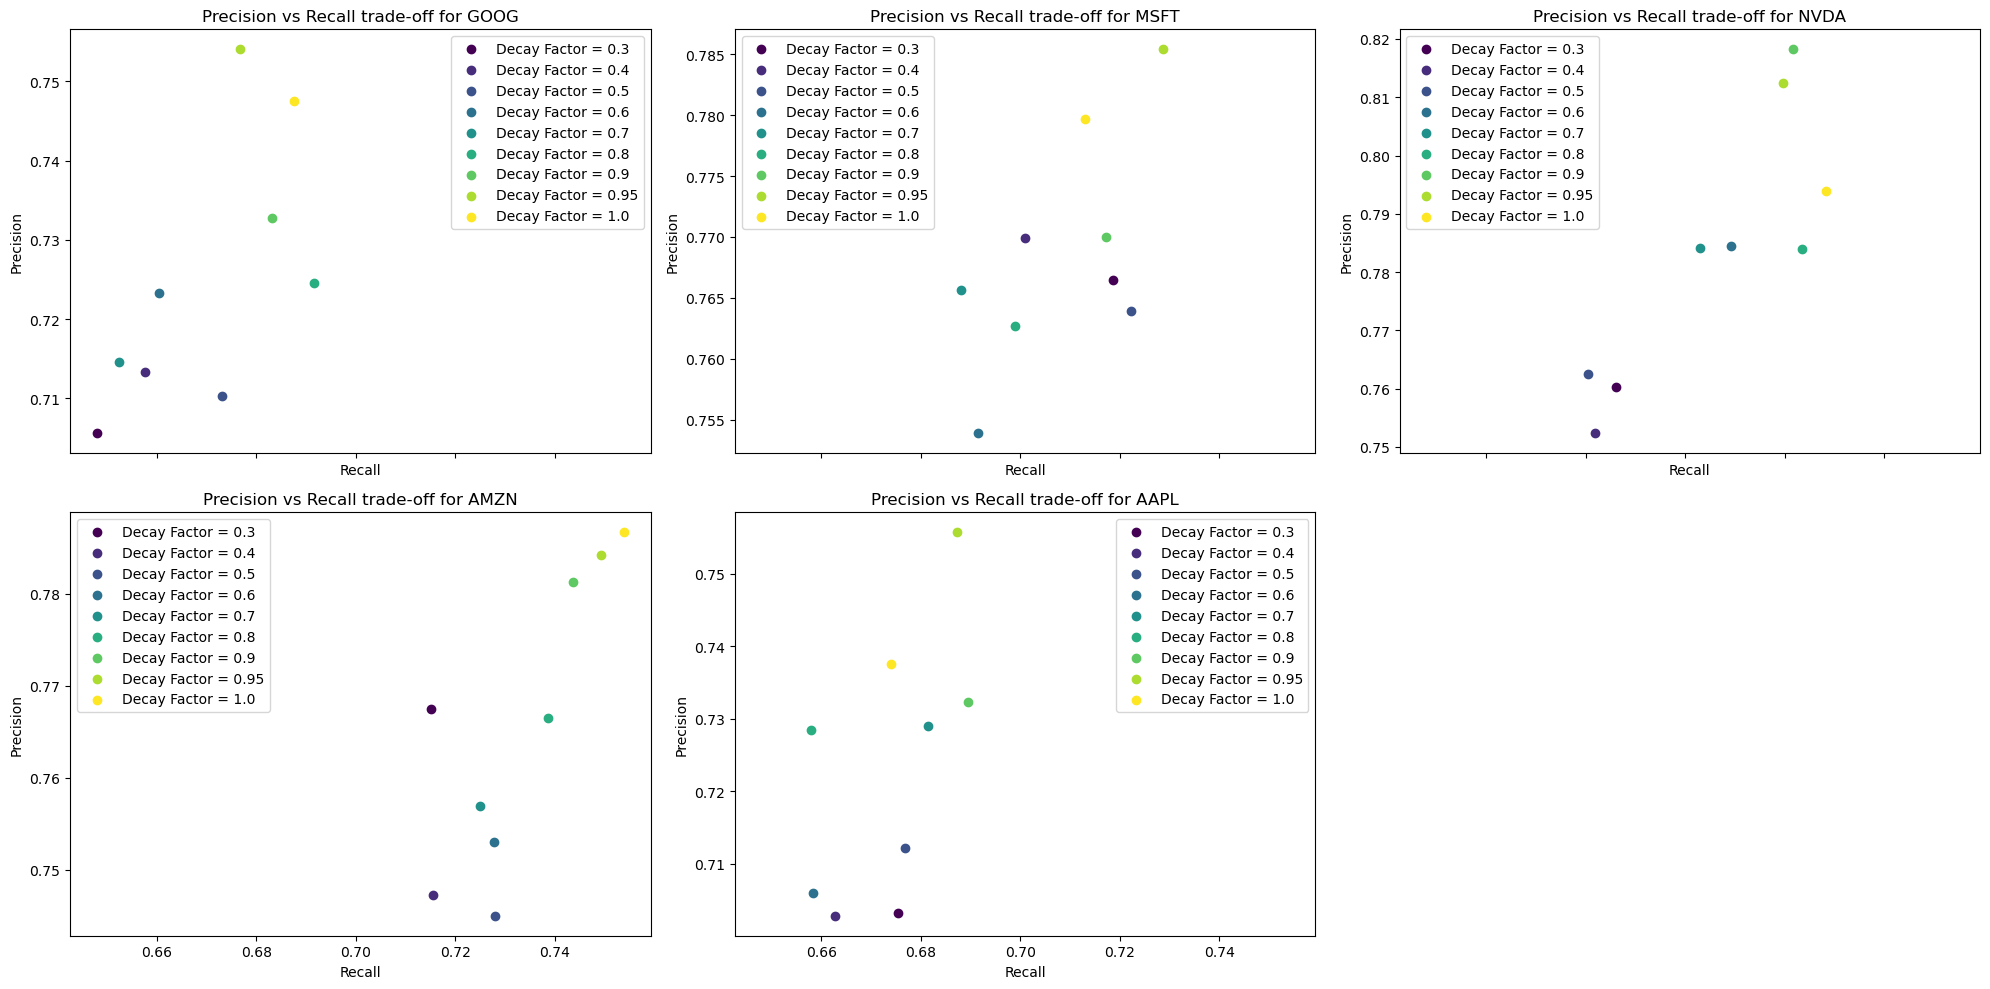

In [359]:
# Calculate the number of rows and columns for subplots
n_symbols = len(stock_symbols)
n_cols = 3  # Adjust this to change the number of columns per row
n_rows = (n_symbols + n_cols - 1) // n_cols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), sharex=True)

# Flatten axes to handle 1D indexing, and handle cases where axes are more than required
axes = axes.flatten()

# Define a color map
colors = cm.viridis(np.linspace(0, 1, len(decay_factors)))

for i, symbol in enumerate(stock_symbols):
    axes[i].set_title(f'Precision vs Recall trade-off for {symbol}')
    
    # Plot each decay factor with a unique color
    for j, decay_factor in enumerate(decay_factors):
        axes[i].scatter(
            recall_scores[symbol][j], 
            precision_scores[symbol][j], 
            label=f'Decay Factor = {decay_factor}', 
            color=colors[j]
        )
    
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].legend(loc='best')

# Hide unused subplots (if any)
for j in range(len(stock_symbols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

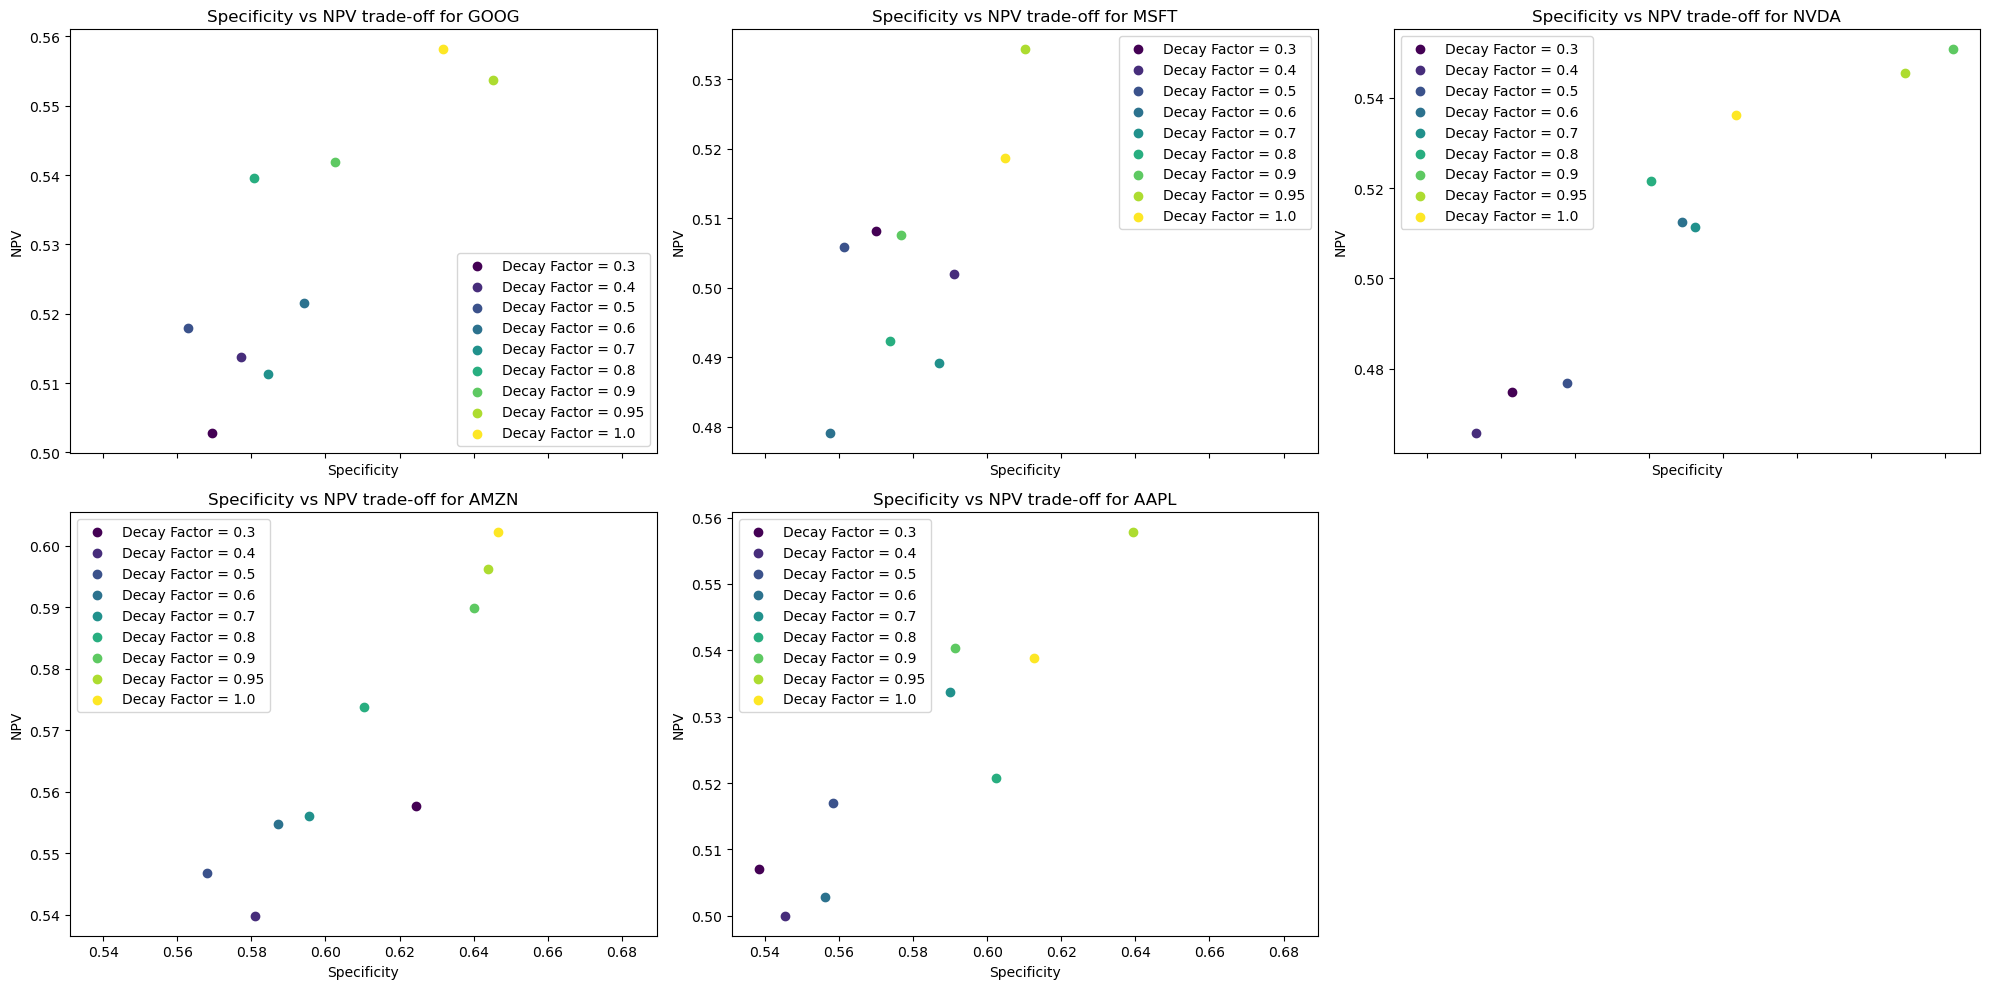

In [360]:
# Calculate the number of rows and columns for subplots
n_symbols = len(stock_symbols)
n_cols = 3  # Adjust this to change the number of columns per row
n_rows = (n_symbols + n_cols - 1) // n_cols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), sharex=True)

# Flatten axes to handle 1D indexing, and handle cases where axes are more than required
axes = axes.flatten()

# Define a color map
colors = cm.viridis(np.linspace(0, 1, len(decay_factors)))

for i, symbol in enumerate(stock_symbols):
    axes[i].set_title(f'Specificity vs NPV trade-off for {symbol}')
    
    # Plot each decay factor with a unique color
    for j, decay_factor in enumerate(decay_factors):
        axes[i].scatter(
            specificity_scores[symbol][j], 
            npv_scores[symbol][j], 
            label=f'Decay Factor = {decay_factor}', 
            color=colors[j]
        )
    
    axes[i].set_xlabel('Specificity')
    axes[i].set_ylabel('NPV')
    axes[i].legend(loc='best')

# Hide unused subplots (if any)
for j in range(len(stock_symbols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()